# Seeloz LSTM+ Notebook


In this notebook we created a models to predict the quantity ordered of a particualr product based on the products order history as well as an embedding of that product in context with products sold in a similar timeframe.

In [0]:
import os
import time
import random
import ast
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorboard.plugins import projector
import collections
import pickle

from collections import Counter

from datetime import datetime, date, timedelta

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle

from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)


DIRS = [os.path.join(dir) for dir in ['output', 'models', 'results']]

for dir in DIRS:
    if not os.path.exists(dir):
        os.makedirs(dir)

MODEL_PATH = os.path.join('models', "model.ckpt")
PROD_PATH = os.path.join('results','products.tsv')




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Loading and preprocessing

The data was provided as set of tables exported from the database of a client of Seeloz.  We processed the data with Google Big Query and exporetd the relavant features as single table. 

### Mount Google Drive and download the Seeloz data file

In [0]:
link='https://drive.google.com/open?id=16erd-Cmgb5zUIVZj_BtWc9vDemTq7Sz9'
fluff, id = link.split('=')
print (id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('preprocessed_data.csv')  

In [0]:
# I encourage you to save the file to your own google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Create the Seeloz DataFrame

In [0]:
seeloz = pd.read_csv('./drive/My Drive/preprocessed_data.csv', parse_dates=['order_date','dispatch_date','received_date']).set_index('order_date')
seeloz.head()

,invoice_item_id,product_id,qty_ordered,qty_delivered,warehouse_id,site_id,dispatch_date,received_date,delivery_time,processing_time,return_reason,qty_returned,return_site,return_warehouse,returned_date,time_bt_delivery_return
order_date,,,,,,,,,,,,,,,,
2013-07-01,36cff80f6835852e0e6dc7500c6fbeba,381e8ce2b223928d17b7dc0b9a1c51b8,-0.000136,0.000423,cb79f8fa58b91d3af6c9c991f63962d3,8e08dbeafdb7e24991ca1bdc37c95656,2013-07-03,2013-07-16,13,2,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-05,495cdb85910b811f44717303591ee80a,381e8ce2b223928d17b7dc0b9a1c51b8,-0.000136,0.000423,cb79f8fa58b91d3af6c9c991f63962d3,ac54bee1b8152c439e9332803941b5b0,2013-04-07,2013-04-11,4,2,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-05,f91d38dd13da48730a813974b65f0fe9,381e8ce2b223928d17b7dc0b9a1c51b8,-0.000197,0.000911,0f28b5d49b3020afeecd95b4009adf4c,919b9a51f6c9feff45f0bae138da82bf,2013-06-05,2013-06-05,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-29,e142dfad01ee25fa273ae4924521a402,381e8ce2b223928d17b7dc0b9a1c51b8,-0.000136,0.000423,cb79f8fa58b91d3af6c9c991f63962d3,c9b0e928de66d2f70cea52bda7d6ba06,2013-01-31,2013-02-18,18,2,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-28,5d5b7177d418f8c29b531109c6c043fd,381e8ce2b223928d17b7dc0b9a1c51b8,-0.000151,0.000326,cb79f8fa58b91d3af6c9c991f63962d3,0173c0bed652f067a94de570926a4534,2013-06-30,2013-07-16,16,2,NaN,NaN,NaN,NaN,NaN,NaN


### Encode the hashed values

We ignore the "return" features as they are very sparse
We save the encoders for later user

In [0]:
hashed = [c for c,d in seeloz.dtypes.items() if d == 'object' and c.find('return')==-1]
print(hashed)

encoders = {}
for c in hashed:
  encoders[c] = LabelEncoder().fit(seeloz[c] )
  seeloz[c] = encoders[c].transform(seeloz[c])
seeloz.head()


['invoice_item_id', 'product_id', 'warehouse_id', 'site_id']


,invoice_item_id,product_id,qty_ordered,qty_delivered,warehouse_id,site_id,dispatch_date,received_date,delivery_time,processing_time,return_reason,qty_returned,return_site,return_warehouse,returned_date,time_bt_delivery_return
order_date,,,,,,,,,,,,,,,,
2013-07-01,781955,156,-0.000136,0.000423,3,249,2013-07-03,2013-07-16,13,2,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-05,1046444,156,-0.000136,0.000423,3,313,2013-04-07,2013-04-11,4,2,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-05,3554197,156,-0.000197,0.000911,0,258,2013-06-05,2013-06-05,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-29,3213720,156,-0.000136,0.000423,3,380,2013-01-31,2013-02-18,18,2,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-28,1332728,156,-0.000151,0.000326,3,4,2013-06-30,2013-07-16,16,2,NaN,NaN,NaN,NaN,NaN,NaN


### Plot the top products (larget orders and most frequent)


We see from the ditributions of total quantities ordered that most of the products have a fairly low total products ordered for the data set with a few products ordered at much higher rates. 

From the frequency of orders we see that the majority of roducts are ordered relatively infrequently with a few products ordere much more frequently. 

Text(0.5, 1.0, 'Box Plot of Order Frequency')

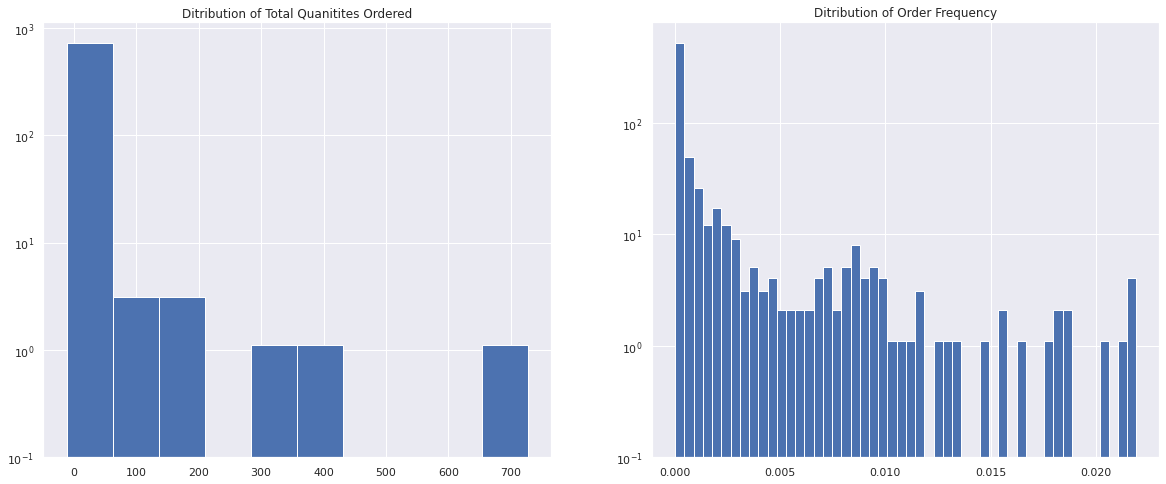

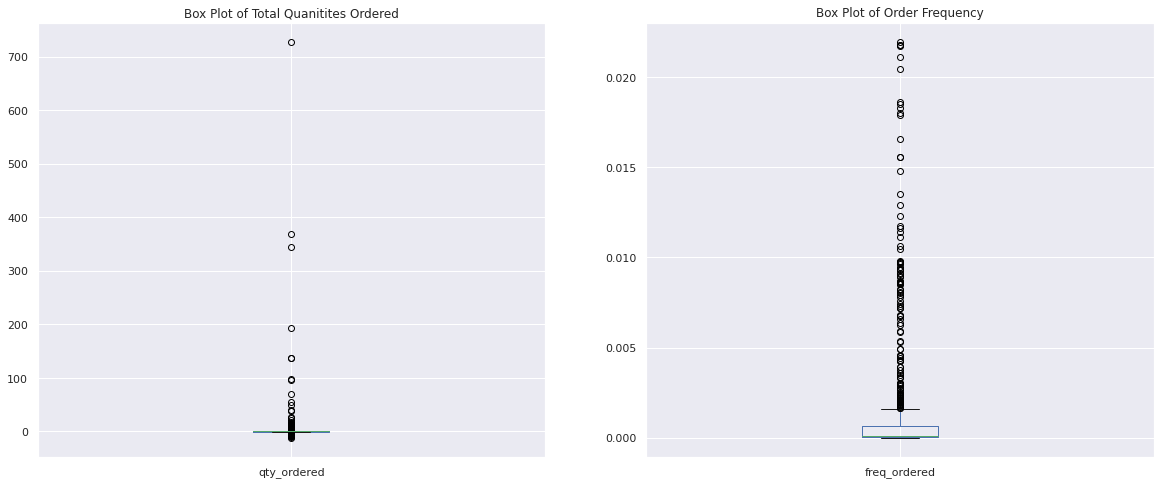

In [0]:
total_orders = seeloz.groupby('product_id').qty_ordered.sum().sort_values(ascending=False)
freq_orders = seeloz.groupby('product_id').qty_ordered.count().sort_values(ascending=False).rename('freq_ordered')/len(seeloz)

fig1, axs = plt.subplots(1,2, figsize=(20,8))
total_orders.hist(ax=axs[0], bins=10, bottom=0.1)
axs[0].set_yscale('log')
axs[0].set_title('Ditribution of Total Quanitites Ordered')

freq_orders.hist(ax=axs[1], bins=50, bottom=0.1)
axs[1].set_yscale('log')
axs[1].set_title('Ditribution of Order Frequency')

print('\n\n')
fig, axs = plt.subplots(1,2, figsize=(20,8))
total_orders.plot.box(ax=axs[0])
#axs[0].set_yscale('log')
axs[0].set_title('Box Plot of Total Quanitites Ordered')

freq_orders.plot.box(ax=axs[1])
axs[1].set_title('Box Plot of Order Frequency')


Next we plot the total quantity and number of sales by week.   We observe an interesting phenomenon in the dataset where there is a big shift in total quantity ordered sometime in the 2nd half of 2010. This may be some artifact of the normilization that was used to anonymize the datast.  

Note that the # of weekly orders seems also to increase over time. We see from the second ploat that this may be because new products are added so the number of products taht can be sold is increasing over time. (what if the same products are just being orderd multiple times?)


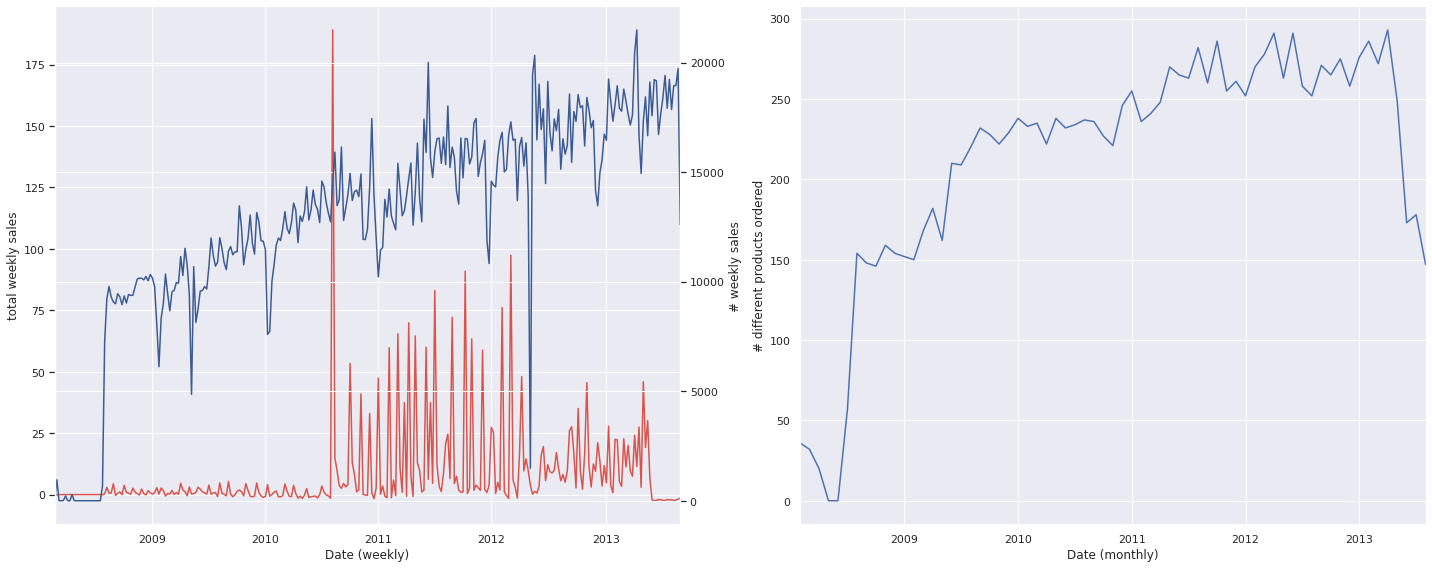

In [0]:
total_weekly_sales = seeloz.groupby(pd.Grouper(freq='W')).qty_ordered.sum()
freq_weekly_sales = seeloz.groupby(pd.Grouper(freq='W')).qty_ordered.count() 


fig,ax = plt.subplots(1,2,figsize=(20,8))
total_weekly_sales.plot(ax=ax[0], c=sns.xkcd_rgb["pale red"])
ax[0].set_ylabel('total weekly sales')
ax2 = ax[0].twinx()
freq_weekly_sales.plot(ax=ax2, c=sns.xkcd_rgb["denim blue"])
ax2.set_ylabel('# weekly sales')
ax[0].set_xlabel('Date (weekly)')

unique_in_month = seeloz.groupby(pd.Grouper(freq='M')).product_id.nunique()
unique_in_month.plot(ax=ax[1])
ax[1].set_ylabel('# different products ordered')
ax[1].set_xlabel('Date (monthly)')

fig.tight_layout()



### Data cleaning 

First lets drop data before 2009 because there is just not much data there.


In [0]:
seeloz = seeloz.sort_index().truncate(before=pd.Timestamp('2009-01-01'))
seeloz.sort_index()

,invoice_item_id,product_id,qty_ordered,qty_delivered,warehouse_id,site_id,dispatch_date,received_date,delivery_time,processing_time,return_reason,qty_returned,return_site,return_warehouse,returned_date,time_bt_delivery_return
order_date,,,,,,,,,,,,,,,,
2009-01-01,2388839,86,-0.000106,-0.000057,0,412,2009-01-01,2009-01-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01,913253,72,-0.000182,-0.000062,0,254,2009-01-01,2009-01-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01,969298,540,0.000243,-0.000035,0,470,2009-01-01,2009-01-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01,1006900,250,-0.000060,-0.000054,0,31,2009-01-01,2009-01-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01,505593,664,-0.000060,-0.000054,2,397,2009-01-01,2009-01-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-08-31,123076,481,-0.000136,0.000180,0,440,2013-08-31,2013-08-31,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-31,2698436,138,-0.000182,-0.000062,0,440,2013-08-31,2013-08-31,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-31,1896649,333,-0.000136,-0.000006,0,440,2013-08-31,2013-08-31,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### The most and least total ordered products 

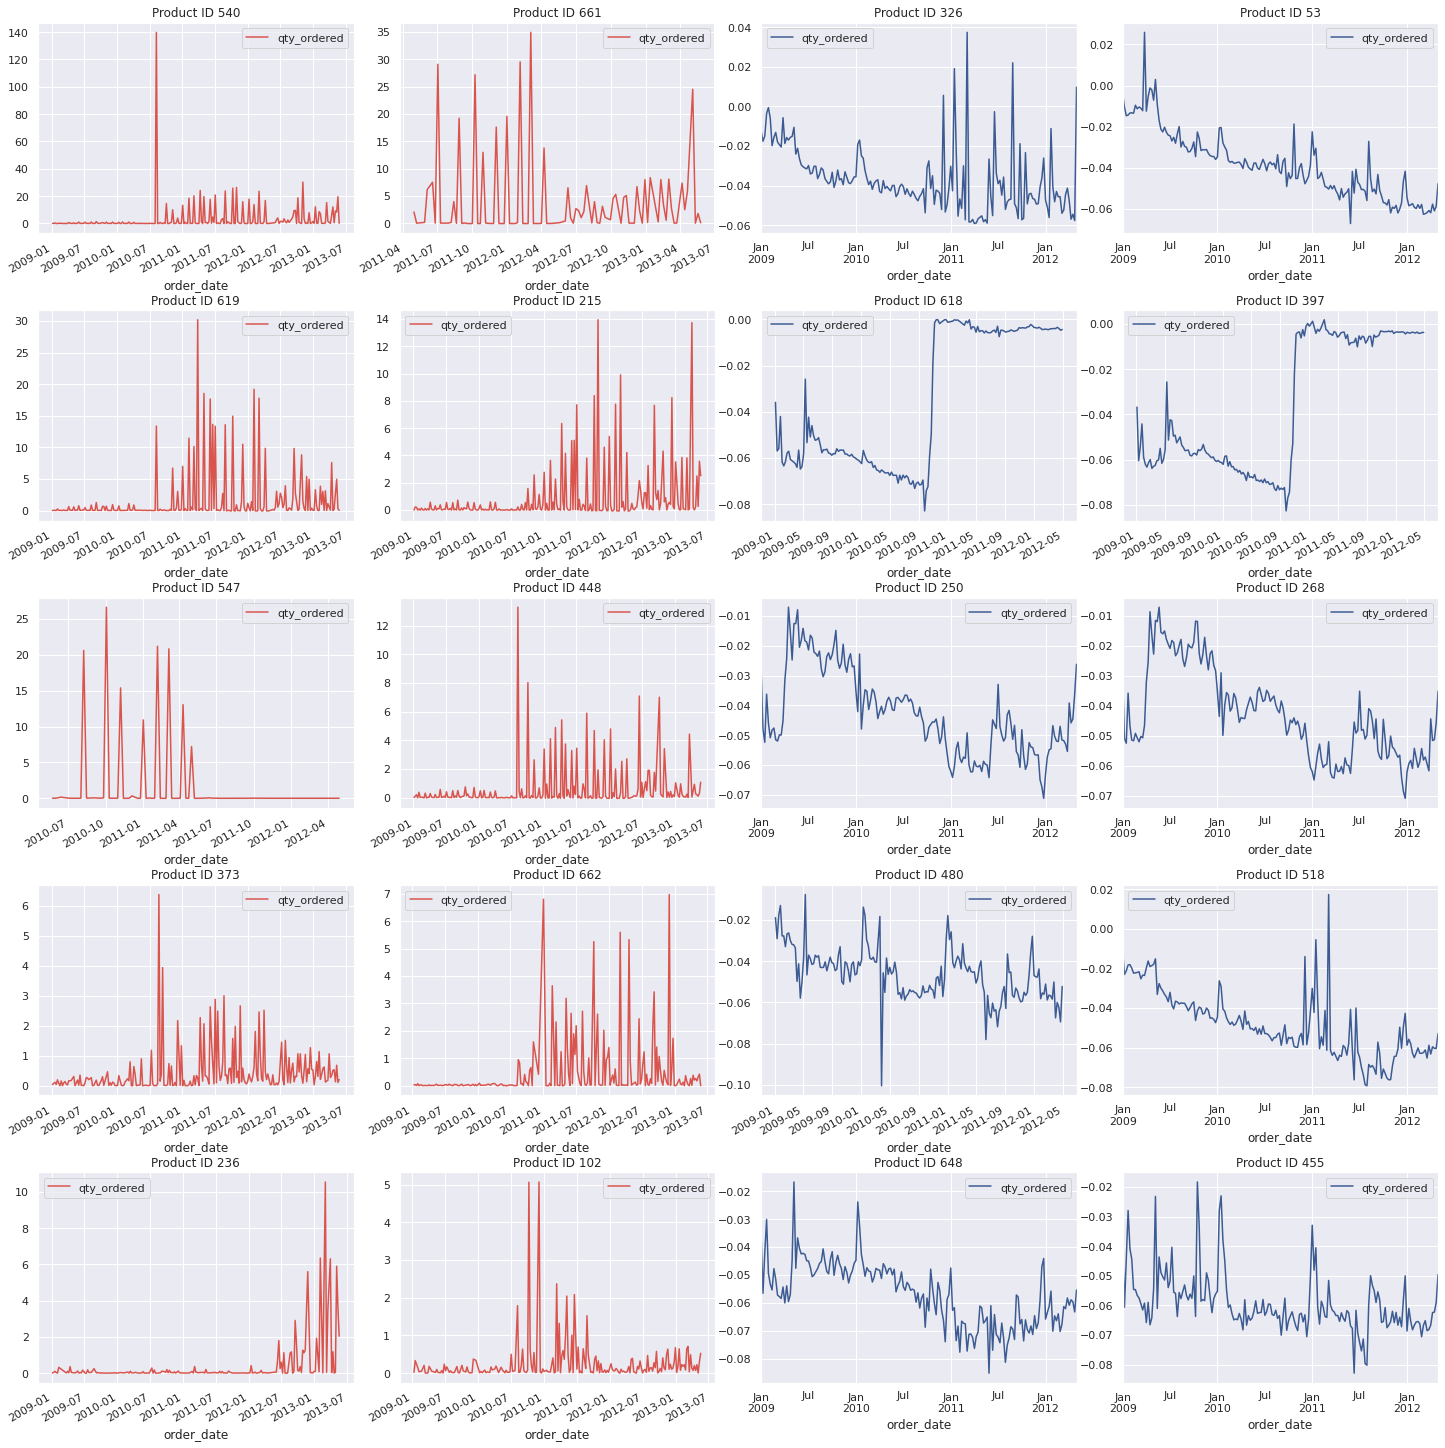

In [0]:
weekly_by_prod = seeloz.groupby([pd.Grouper(freq='W'),'product_id']).qty_ordered.sum().reset_index()
limit = 10
fig,ax = plt.subplots(5,4,figsize=(20,20))
i = 0
j = 0 
for prod in total_orders.index[:limit]:
  weekly_by_prod[weekly_by_prod['product_id']==prod][['order_date','qty_ordered']].set_index('order_date').plot(ax=ax[i,j], c=sns.xkcd_rgb["pale red"])
  ax[i,j].set_title(f'Product ID {prod}')
  j+=1
  if j%2==0:
    j = 0
    i +=1

j=2
i=0
for prod in total_orders.index[-10:]:
  weekly_by_prod[weekly_by_prod['product_id']==prod][['order_date','qty_ordered']].set_index('order_date').plot(ax=ax[i,j], c=sns.xkcd_rgb["denim blue"])
  ax[i,j].set_title(f'Product ID {prod}')
  j+=1
  if j%4==0:
    j = 2
    i +=1


fig.tight_layout(pad=0.3)



### The most and least frequently ordered products

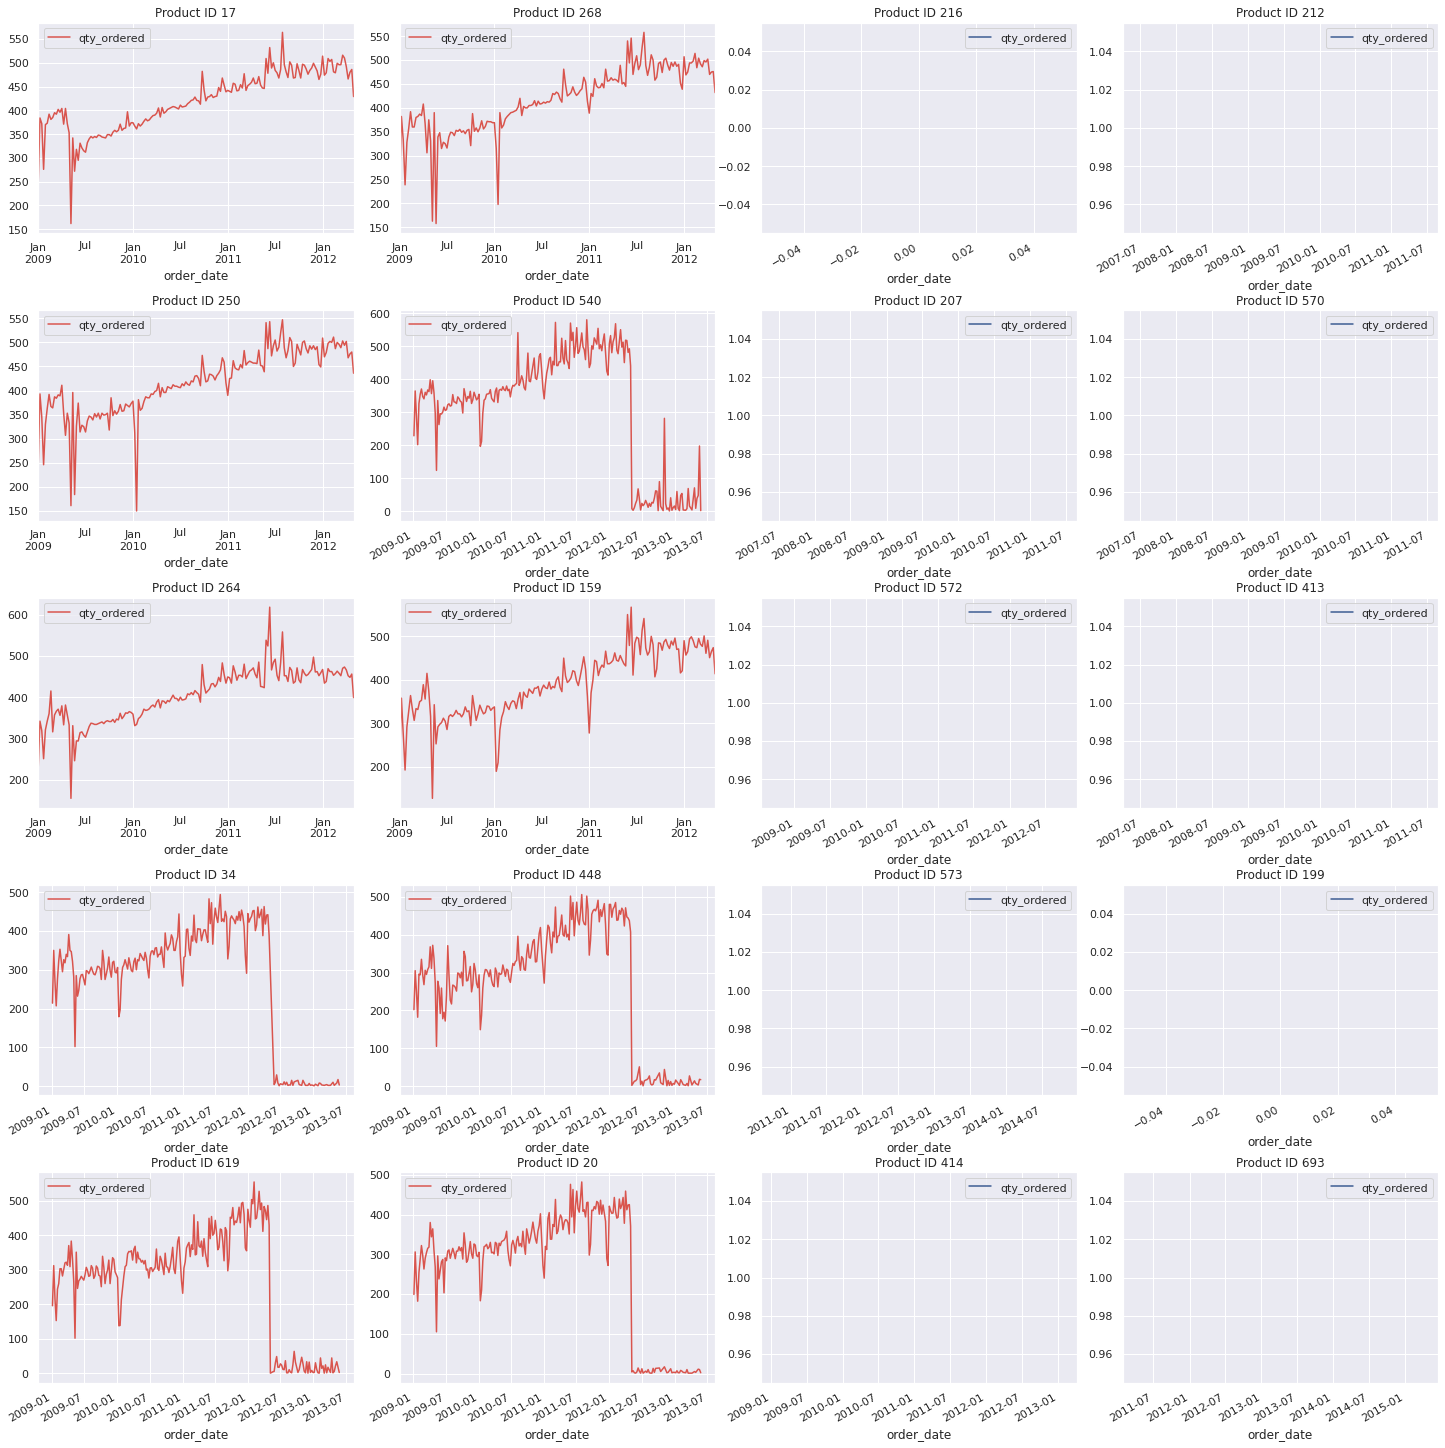

In [0]:
weekly_by_prod = seeloz.groupby([pd.Grouper(freq='W'),'product_id']).qty_ordered.count().reset_index()
limit = 10
fig,ax = plt.subplots(5,4,figsize=(20,20))
i = 0
j = 0 
for prod in freq_orders.index[:limit]:
  weekly_by_prod[weekly_by_prod['product_id']==prod][['order_date','qty_ordered']].set_index('order_date').plot(ax=ax[i,j], c=sns.xkcd_rgb["pale red"])
  ax[i,j].set_title(f'Product ID {prod}')
  j+=1
  if j%2==0:
    j = 0
    i +=1

j=2
i=0
for prod in freq_orders.index[-10:]:
  weekly_by_prod[weekly_by_prod['product_id']==prod][['order_date','qty_ordered']].set_index('order_date').plot(ax=ax[i,j], c=sns.xkcd_rgb["denim blue"])
  ax[i,j].set_title(f'Product ID {prod}')
  j+=1
  if j%4==0:
    j = 2
    i +=1


fig.tight_layout(pad=0.3)

Observe the most infrequently ordered products have no actual orders so lets remove them

In [0]:
most_infrequent = freq_orders[freq_orders<0.0000005]
print(f'Removing the {len(most_infrequent)} most infrequent orders')
seeloz = seeloz[~seeloz['product_id'].isin(most_infrequent.index)]

Removing the 53 most infrequent orders


### Group the Seeloz data by week

We need to aggregate the data by week to smooth out the trends and get ready for weekly predictions

by:
* qty_ordered: sum
* qty_delivered: sum
* delivery_time: mean
* processing_time: mean

In [0]:
# ## this is slow operation so we save it to the drive afterwards
def my_agg(x):
    data = {'qty_ordered': x.qty_ordered.sum(),
            'qty_delivered':x.qty_delivered.sum(),
            'delivery_time':x.delivery_time.mean(),
            'processing_time':x.processing_time.mean(),
            'warehouse_id':[list(x).count(i) for i in range(len(encoders['warehouse_id'].classes_))],
            'site_id': [list(x).count(i) for i in range(len(encoders['site_id'].classes_))]}
    return pd.Series(data)

tqdm.pandas()
weeklys = seeloz.groupby([pd.Grouper(freq='W'), 'product_id']).progress_apply(my_agg).reset_index()

## Saving a backup of the grouped data
path = './drive/My Drive/weeklys.csv'
weeklys.to_csv(path)


In [0]:
## test that file is saved
path = './drive/My Drive/weeklys.csv'
weeklys = pd.read_csv(path, index_col=0, parse_dates = ['order_date'], converters={'warehouse_id':ast.literal_eval,'site_id':ast.literal_eval})
weeklys.head()

# Model Description

The ides is to create two inputs to the model. We would like to retain some contextual infomration about the product.  To this end we follow a the stratgey developed for Word2Vec and Stock2Vec and create a vector embedding for each product.   

# products2vec
define model parameters

In [0]:
window_size = 10
n_embedding = 50
epochs = 100
n_prods =  len(seeloz['product_id'].unique())
print('Number of products: ',n_prods)
print('Number of sites: ', len(seeloz['site_id'].unique()))

Convereting embedding columns to list to speed up python

In [0]:
embedding_columns = ['order_date', 'product_id', 'site_id']
prod_dict = {}
for name in embedding_columns:
  print(name)
  prod_dict[name] = seeloz.reset_index()[name].tolist()

order_date
product_id
site_id


### Prepare the inputs

Create two lookup tables for prodcut_id and site_id

In [0]:
int_to_product = {}
product_to_int = {}

def get_product_int(idx):
    product = prod_dict['product_id'][idx]
    key = product_to_int.get(product, None)
    if key is None:
        key = product_to_int[product] = len(product_to_int)
        int_to_product[key] = product
    return key

### Date Window Function 

finds a  random window size of products that were ordered within a 1 week range

In [0]:
# This windowing function is implemented later when creating training batches
# It gets a random window of products sold on the same day as a given product

def get_date_window(idx, total, window_size=5):
  R = np.random.randint(1, window_size+1)
  start = idx - R if (idx - R) > 0 else 0
  stop = idx + R if (idx + R) < total else total

  prod_int = get_product_int(idx)
  prod_date = prod_dict['order_date'][idx]
  delta = pd.Timedelta(0.5,'W')
  date_range = (prod_date-delta, prod_date+delta)


  window = []

  for i in range(start, stop):
    nearby_prod_int = get_product_int(i)
    nearby_prod_date = prod_dict['order_date'][i]
    if nearby_prod_int != prod_int and nearby_prod_date>= date_range[0] and nearby_prod_date <=date_range[1] :
      window.append(nearby_prod_int)
  
  return window
  
# a test of the date window function
for idx in range(100,120,9):
  print(f'Date window for product id {prod_dict["product_id"][idx]}', end = ': [ ')
  for nearby_id in get_date_window(idx, len(prod_dict['product_id']), 5):
    print(nearby_id, end = ' ')
  print(']\n')

Date window for product id 622: [ 1 2 3 4 5 6 7 8 9 ]

Date window for product id 20: [ 10 ]

Date window for product id 215: [ 12 8 4 13 1 14 15 ]



### Site Window Function 

finds a random window size of products that were ordered by the same site

In [0]:
def get_site_window(idx, total, window_size=5):
  R = np.random.randint(1, window_size+1)
  start = idx - R if (idx - R) > 0 else 0
  stop = idx + R if (idx + R) < total else total
  # print('start: ' , start, '\nstop: ', stop)
  # prod_id = prod_dict['product_id_enc'][idx]
  prod_int = get_product_int(idx)
  prod_date = prod_dict['order_date'][idx]
  site_id = prod_dict['site_id'][idx]

  # print('product id: ', prod_id, '\nproduct date:', prod_date)

  window = []

  for i in range(start, stop):
    nearby_prod_int = get_product_int(i)
    nearby_prod_date = prod_dict['order_date'][i]
    nearby_site_id = prod_dict['site_id'][i]
    #print(nearby_prod_inv, prod_inv)
    if nearby_prod_int != prod_int and nearby_site_id == site_id:
      window.append(nearby_prod_int)
  
  return window

# a test of the site window function
for idx in range(0,20,9):
  print(f'Site window for product id {prod_dict["product_id"][idx]}', end=': [ ')
  for nearby_id in get_site_window(idx, len(prod_dict['product_id']), 5):
    print(nearby_id, end= ' ')
  print('] \n')


Site window for product id 86: [ ] 

Site window for product id 622: [ 15 12 ] 

Site window for product id 250: [ ] 



### Create Batches for Tensoflow API


In [0]:
batch_size = 10000
window_size = 10

total_quant = len(seeloz['product_id'])

pbar= tqdm(total=int(total_quant / batch_size))

def get_batch(start):
  x, y = [], []

  stop = start + batch_size if (start + batch_size) < total_quant else total_quant

  for i in range(start, stop):
    # batch_x = prod_dict['product_id_enc'][i]
    batch_x = get_product_int(i)
    batch_y = get_date_window(i, total_quant, window_size=window_size) + get_date_window(i, total_quant, window_size=window_size) 
    y.extend(batch_y)
    x.extend([batch_x]*len(batch_y))
 
  pbar.update() 
  return [x,y]

def get_batches():
  batches = []

  for start in range(0, total_quant, batch_size):
    batches.append(get_batch(start))
    
  
  return batches

batches = get_batches()

### Build the Graph

This is a tensorflow V1 implementation 

In [0]:

train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.compat.v1.placeholder(tf.int32, [None], name='inputs')
    labels = tf.compat.v1.placeholder(tf.int32, [None, None], name='labels')
    embedding = tf.Variable(tf.random.uniform((n_prods, n_embedding), -1, 1), name='prod_embedding')
    embed = tf.nn.embedding_lookup(embedding, inputs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Negative Sampling

In [0]:
# Number of negative labels to sample
n_sampled = 100

with train_graph.as_default():
    softmax_w = tf.Variable(tf.random.truncated_normal((n_prods, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_prods))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_prods)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.compat.v1.train.AdamOptimizer().minimize(cost)

### Training Setup

In [0]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    upper_bound = n_prods

  
    # pick 8 samples from bottom 100 and top 100. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(upper_bound-valid_window,upper_bound), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keepdims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

### Train product2vec

In [0]:
epochs = 100

with train_graph.as_default():
    saver = tf.compat.v1.train.Saver()

with tf.compat.v1.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.compat.v1.global_variables_initializer())

    for e in range(1, epochs+1):
        start = time.time()
        for batch in batches:
            x = batch[0]
            y = batch[1]
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_prod = int_to_product[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_prod
                    for k in range(top_k):
                        try:
                            close_prod = int_to_product[nearest[k]]
                            log = '%s %s,' % (log, close_prod)
                        except Exception:
                            print('nearest[k]', nearest[k])
                    print(log)

                    # save the model and the embedding matrix
                
                save_path = saver.save(sess, MODEL_PATH)
                embed_mat = sess.run(normalized_embedding)
                e_m_path = f'./results/embed_mat_e{e}.pkl'
                with open(e_m_path, 'wb') as handle:
                    pickle.dump(embed_mat, handle)

            
            iteration += 1




### Save the models and the lookup tables

In [0]:
# save the model and the embedding matrix
save_path = saver.save(sess, MODEL_PATH)
embed_mat = sess.run(normalized_embedding)

e_m_path = f'./results/embed_mat_e{e}.pkl'
p_t_i_path = '/drive/My Drive/product_to_int.pkl'
e_m_path = '/drive/My Drive/embed_mat.pkl'

with open(e_m_path, 'wb') as handle:
    pickle.dump(embed_mat, handle)

with open(p_t_i_path, 'wb') as handle:
    pickle.dump(product_to_int, handle)

with open(e_m_path, 'wb') as handle:
    pickle.dump(embed_mat, handle)


### Plot the clusters created by products2vec

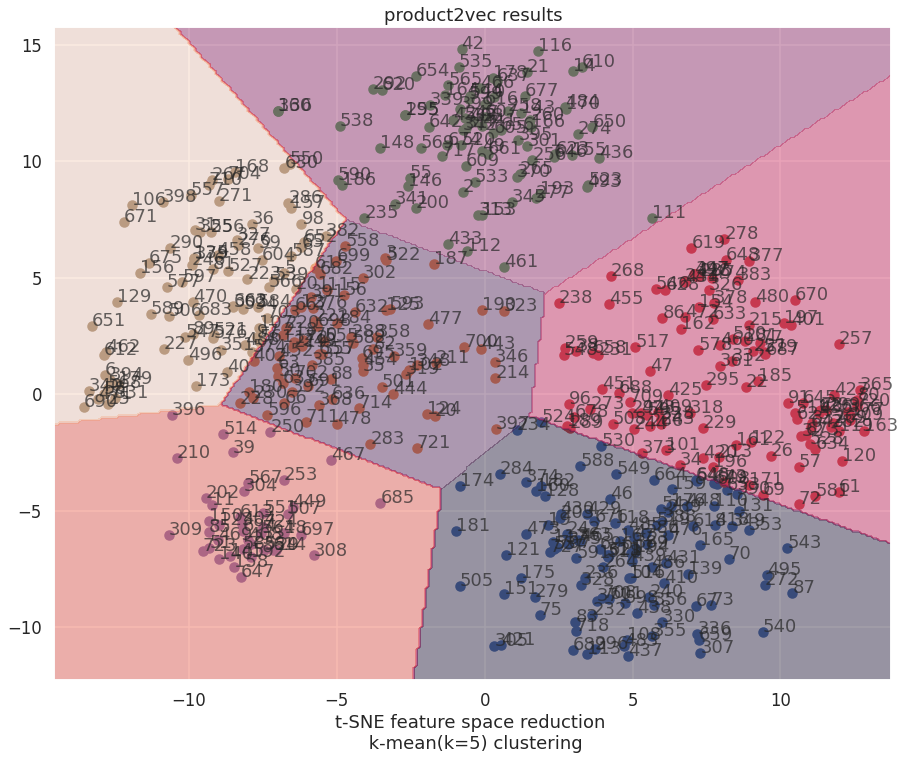

In [0]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context("talk")
viz_prods = 500
tsne = TSNE(perplexity=50)
embed_tsne = tsne.fit_transform(embed_mat[:viz_prods, :])

km = KMeans(init='k-means++',n_clusters=6)

groups = km.fit_predict(embed_tsne)
np.unique(groups)

current_palette = sns.color_palette()

fig, ax = plt.subplots(figsize=(15, 12))
for idx in range(1,viz_prods):
    color = current_palette[groups[idx]]
    plt.scatter(*embed_tsne[idx, :], color=color)
    plt.annotate(int_to_product[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7, )

# Plotting decision regions
x_min, x_max = embed_tsne[:, 0].min() - 1, embed_tsne[:, 0].max() + 1
y_min, y_max = embed_tsne[:, 1].min() - 1, embed_tsne[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = km.predict(np.array([xx.ravel(), yy.ravel()]).T)
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, alpha=0.4)
plt.title('product2vec results')
ax.set_xlabel('t-SNE feature space reduction \n k-mean(k=5) clustering')
plt.savefig('./drive/My Drive/tsne_plot.png')

In [0]:
# Using an alternative embedding from the tf notebook

# retrieve the alternative embedding table and the product to int vector

path = './drive/My Drive/embed_mat_e100.pkl'
with open(path, 'rb') as handle:
   embed_mat = pickle.load(handle)

path = './drive/My Drive/product2int.pkl'
with open(path, 'rb') as handle:
   product2int = pickle.load(handle)
    
prod_embeddings = {w:embed_mat[idx] for w, idx in product2int.items()}
prod_embeddings[540]


array([-0.22280777, -0.08688937,  0.06417979, -0.22117224, -0.03091248,
        0.05875761, -0.03971934, -0.04569739, -0.14223392, -0.16513854,
        0.06814209, -0.11784796, -0.07684794,  0.00070825,  0.06291274,
       -0.16513333,  0.00746   , -0.03389879,  0.07870083, -0.16074388,
        0.13693671, -0.03566132, -0.18334192, -0.02974994, -0.08963197,
       -0.03424363,  0.03619917, -0.19248162, -0.08352255,  0.11016402,
       -0.06984732, -0.14510474, -0.14989251,  0.07385727,  0.04333653,
        0.08810201,  0.03584089, -0.01538557,  0.20580287,  0.32560283,
       -0.01945768, -0.5064206 , -0.02103554,  0.12656365,  0.0712909 ,
        0.14918415, -0.02239595, -0.12135694, -0.30418384,  0.04802403],
      dtype=float32)

# LSTM inputs

create a dataframe of sequences

### Filling in Zero Rows for products with no orders for a give week

also a helper function for converting np.datetime64 to datetime

In [0]:
num_prods = weeklys['product_id'].unique()

def ts_converter(np_ts):
  ts = (np_ts - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
  return datetime.utcfromtimestamp(ts)

def unit_week_converter(df, date_col, unit_col):
  # fill in products by week with zeros when there was no product ordered
  weeks = df[date_col].unique()

  min_date = min(weeks)
  max_date = max(weeks)

  start_date = ts_converter(min_date)
  end_date = ts_converter(max_date)
  delta = timedelta(days=7)

  unit_week = pd.DataFrame(columns=df.columns)

  with tqdm(total=len(weeks)) as pbar:
    while start_date <= end_date:
      i=0
      for i in df[unit_col].unique():
        row = df[(df[date_col] == start_date) & (df[unit_col]==i)]
        if row.empty:
          row = {'order_date':start_date,'product_id':i, 
                'qty_ordered':0,	'qty_delivered':0,	
                'delivery_time':0,'processing_time':0,
                'warehouse_id':[], 'site_id':[],
                'invoice_item_id':[]}

          unit_week = unit_week.append(row, ignore_index=True)
        else:
          # unit_week = unit_week.append(row,ignore_index=True)
          unit_week = pd.concat([unit_week, row])
      start_date += delta
      pbar.update(1)

  return unit_week.sort_values(['product_id', 'order_date']).reset_index(drop=True)

In [0]:
## convert to unit weeks and save the data (slow)
# unit_week = unit_week_converter(weeklys, 'order_date', 'product_id')
unit_week_converter(weeklys, 'order_date', 'product_id')

In [0]:
unit_week[unit_week['product_id']==0].set_index('order_date').sort_index().head()

In [0]:
# save or import data
path = './drive/My Drive/unit_week.csv'
#unit_week.to_csv(path)
unit_week = pd.read_csv(path, index_col=0, parse_dates = ['order_date'],converters={'warehouse_id':ast.literal_eval,'site_id':ast.literal_eval,'invoice_item_id':ast.literal_eval})
unit_week.columns

In [0]:
unit_week.head()

,order_date,product_id,qty_ordered,qty_delivered,delivery_time,processing_time,warehouse_id,site_id
0,2009-01-04,4,0.000721,0.022064,0.0,20.755102,"[0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2009-01-04,17,0.000549,0.015657,0.0,1.325000,"[0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2009-01-04,19,0.000897,0.024353,0.0,0.000000,"[0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,2009-01-04,20,0.000537,0.016783,0.0,1.281407,"[0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,2009-01-04,34,0.000525,0.016286,0.0,1.308411,"[0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Scaling the data

In [0]:
unit_week = weeklys.copy()
ordered_scaler = MinMaxScaler()
delivered_scaler = MinMaxScaler()
unit_week['qty_ordered'] = ordered_scaler.fit_transform(np.array(unit_week['qty_ordered']).reshape(-1, 1))
unit_week['qty_delivered'] = delivered_scaler.fit_transform(np.array(unit_week['qty_delivered']).reshape(-1, 1))

### Temporal DataFrame Creator


In [0]:
weeks_in_sequence = 8

def temporal_df_creator(train_df, weeks_in_sequence):

  trend_list = []

  with tqdm(total=len(list(train_df.product_id.unique()))) as pbar:
      for product in train_df.product_id.unique():
          product_df = train_df.query(f"product_id=={product}").reset_index(drop=True)
          
          #I added a quick hack to double the number of sequences
          #Warning: This will later create a minor leakage from the 
          # training set into the validation set.
          for i in range(0,len(product_df),int(weeks_in_sequence/2)):
              if i+weeks_in_sequence<=len(product_df):
                  #prepare all the scaler temporal inputs
                  qty_ordered = [float(x) for x in product_df[i:i+weeks_in_sequence-1].qty_ordered.values]
                  qty_delivered = [float(x) for x in product_df[i:i+weeks_in_sequence-1].qty_delivered.values]
                  delivery_time = [float(x) for x in product_df[i:i+weeks_in_sequence-1].delivery_time.values]
                  processing_time = [float(x) for x in product_df[i:i+weeks_in_sequence-1].processing_time.values]

                  #getting the embeding vector
                  prod_embedding = prod_embeddings[product]

                  #targets
                  expected_qty = float(product_df.iloc[i+weeks_in_sequence-1].qty_ordered)

                  #order_date
                  order_date = product_df.iloc[i+weeks_in_sequence-1].order_date


                  trend_list.append({'product_id':product,
                                     'order_date': order_date,
                                     'qty_ordered':qty_ordered,
                                     'qty_delivered':qty_delivered,
                                     'delivery_time': delivery_time, 
                                     'processing_time':processing_time,
                                     'prod_embedding':prod_embedding, 
                                     'expected_qty':expected_qty})

          pbar.update(1)
  return trend_list


trend_df = pd.DataFrame(temporal_df_creator(unit_week, 8))

#### add a `temporal_inputs' feature

In [0]:
trend_df["temporal_inputs"] = [np.asarray([trends["qty_ordered"],
                                           trends["qty_delivered"],
                                           trends["delivery_time"],
                                           trends["processing_time"],
                                           ]) for _,trends in trend_df.iterrows()]
trend_df = shuffle(trend_df)
trend_df.head()

,product_id,order_date,qty_ordered,qty_delivered,delivery_time,processing_time,prod_embedding,expected_qty,temporal_inputs
5218,294,2010-01-31,"[0.0007264262293716573, 0.0007362656364789861,...","[0.022176246138654997, 0.022428905488000438, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.3043478260869565, 1.4102564102564104, 1.383...","[-0.0146579705, 0.007752865, 0.14660081, 0.030...",0.000729,"[[0.0007264262293716573, 0.0007362656364789861..."
2578,540,2010-09-05,"[0.0009183677947202278, 0.001331102701637645, ...","[0.013528600350041739, 0.014395185859257592, 0...","[0.002631578947368421, 0.0, 0.0025773195876288...","[1.1894736842105262, 1.361038961038961, 1.5927...","[-0.22280777, -0.08688937, 0.06417979, -0.2211...",0.001216,"[[0.0009183677947202278, 0.001331102701637645,..."
8948,592,2012-07-29,"[0.0007614605802736888, 0.0007627579397921367,...","[0.023213204304006408, 0.02324093097034729, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.47619047619047616, 0.0, 0.478260869565...","[-0.17967965, 0.27581134, 0.023860138, 0.16885...",0.000764,"[[0.0007614605802736888, 0.0007627579397921367..."
2058,427,2010-04-18,"[0.0007875198033135856, 0.0007879547648881529,...","[0.023702801101529784, 0.023676190105378605, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.25, 1.4, 1.4285714285714286, 1.0, 1.0, 1.25...","[-0.0073446133, -0.102532245, 0.0019150488, -0...",0.000790,"[[0.0007875198033135856, 0.0007879547648881529..."
7225,581,2011-07-10,"[0.013476219594203736, 0.06428371095901199, 0....","[0.02816844214092757, 0.04671684192636898, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[95.07407407407408, 52.36434108527132, 10.4418...","[0.030040063, -0.0409756, -0.06756041, -0.0979...",0.029036,"[[0.013476219594203736, 0.06428371095901199, 0..."


Save the final dataframe

In [0]:
# save or import data
path = './drive/My Drive/trend_df.csv'
list_cols = [c for c,t in trend_df.dtypes.items() if t == 'object']
print(list_cols)

trend_df.to_csv(path)
#trend_df = pd.read_csv(path, index_col=0,converters={c:ast.literal_eval for c in ['qty_ordered', 'qty_delivered', 'delivery_time', 'processing_time', 'warehouse_id', 'site_id', 'prod_embedding', 'temporal_inputs']})
# trend_df.head()

['qty_ordered', 'qty_delivered', 'delivery_time', 'processing_time', 'prod_embedding', 'temporal_inputs']


## Setup Train, Validations, and Test Sets

In [0]:
temporal_vectors, sequence_length = trend_df.temporal_inputs.iloc[0].shape
vector_dim = trend_df.prod_embedding.iloc[0].shape[0]
training_percentage = 0.8
test_percentage = 0.1

In [0]:
training_item_count = int(len(trend_df)*training_percentage)
testing_item_count =int(len(trend_df)*test_percentage)
validation_item_count = len(trend_df)-training_item_count-testing_item_count
training_df = trend_df.iloc[:training_item_count,:]
validation_df = trend_df.iloc[training_item_count:validation_item_count+training_item_count,:]
testing_df = trend_df.iloc[validation_item_count+training_item_count:,:]

print(training_item_count, training_df.shape)
print(validation_item_count, validation_df.shape)
print(testing_item_count, testing_df.shape)

7506 (7506, 9)
939 (939, 9)
938 (938, 9)


In [0]:
X_temporal_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in training_df["temporal_inputs"].values]),(training_item_count,temporal_vectors,sequence_length)),(0,2,1) )).astype(np.float32)
X_embedding_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in training_df["prod_embedding"].values]),(training_item_count,vector_dim)),(0,1) )).astype(np.float32)
Y_quant_train = np.asarray([np.asarray(x) for x in training_df["expected_qty"]]).astype(np.float32)

X_temporal_valid = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_df["temporal_inputs"]]),(validation_item_count,temporal_vectors,sequence_length)),(0,2,1)) ).astype(np.float32)
X_embedding_valid = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_df["prod_embedding"].values]),(validation_item_count,vector_dim)),(0,1) )).astype(np.float32)
Y_quant_valid = np.asarray([np.asarray(x) for x in validation_df["expected_qty"]]).astype(np.float32)

X_temporal_test = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in testing_df["temporal_inputs"]]),(testing_item_count,temporal_vectors,sequence_length)),(0,2,1)) ).astype(np.float32)
X_embedding_test = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in testing_df["prod_embedding"].values]),(testing_item_count,vector_dim)),(0,1) )).astype(np.float32)
Y_quant_test = np.asarray([np.asarray(x) for x in testing_df["expected_qty"]]).astype(np.float32)


In [0]:
print('X temporal train shape:', X_temporal_train.shape)
print('X embedding train shape:', X_embedding_train.shape)
print('Y quantity train shape: ', Y_quant_train.shape)
print()
print('X temporal validation shape:', X_temporal_valid.shape)
print('X tempembedding validation shape:', X_embedding_valid.shape)
print('Y quantity validation shape:', Y_quant_valid.shape)
print()
print('X temporal test shape:', X_temporal_test.shape)
print('X tempembedding test shape:', X_embedding_test.shape)
print('Y quantity test shape:', Y_quant_test.shape)

X temporal train shape: (7506, 7, 4)
X embedding train shape: (7506, 50)
Y quantity train shape:  (7506,)

X temporal validation shape: (939, 7, 4)
X tempembedding validation shape: (939, 50)
Y quantity validation shape: (939,)

X temporal test shape: (938, 7, 4)
X tempembedding test shape: (938, 50)
Y quantity test shape: (938,)


# Create LSTM and LSTM+ Prediction Models

LSTM Model Setup

In [0]:
#temporal input branch
temporal_input_layer = Input(shape=(sequence_length,temporal_vectors))
main_rnn_layer = layers.LSTM(64, return_sequences=True, recurrent_dropout=0)(temporal_input_layer)


#quant output branch
rnn = layers.LSTM(32)(main_rnn_layer)
dense = layers.Dense(128)(rnn)
dropout = layers.Dropout(0.3)(dense)
quant = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1),name="qty_ordered")(dropout)

lstm_only_model = Model(temporal_input_layer, quant)

lstm_only_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 4)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 7, 64)             17664     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 128)               4224      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
qty_ordered (Dense)          (None, 1)                 129       
Total params: 34,433
Trainable params: 34,433
Non-trainable params: 0
_________________________________________________________

LSTM+ Setup (LSTM + product2vev embedding)

In [0]:
#temporal input branch
temporal_input_layer = Input(shape=(sequence_length,temporal_vectors))
main_rnn_layer = layers.LSTM(64, return_sequences=True, recurrent_dropout=0)(temporal_input_layer)

#embedding input branch
embedding_input_layer = Input(shape=(vector_dim))
embedding_dense = layers.Dense(50)(embedding_input_layer)
embedding_dropout = layers.Dropout(0.2)(embedding_dense)

#quant output branch
rnn = layers.LSTM(32)(main_rnn_layer)
merge= layers.Concatenate(axis=-1)([rnn, embedding_dropout])
dense = layers.Dense(128)(merge)
dropout = layers.Dropout(0.3)(dense)
quant = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1),name="qty_ordered")(dropout)


lstm_embedding_model = Model([temporal_input_layer, embedding_input_layer], quant)

lstm_embedding_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 7, 4)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 7, 64)        17664       input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           2550        input_3[0][0]                    
____________________________________________________________________________________________

Setup callback and compile models with MAPE loss and adam optimizer

In [0]:
l_callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='./drive/My Drive/LSTM_only_modelv2.h5', monitor='val_loss', save_best_only=True)]
le_callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='./drive/My Drive/LSTMandEmbedding_model_tfv2.h5', monitor='val_loss', save_best_only=True)]

lstm_only_model.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(), optimizer="adam")
lstm_embedding_model.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(), optimizer="adam")


## Train Models

In [0]:
l_history_extra = lstm_only_model.fit(X_temporal_train, Y_quant_train, 
          epochs = 500, 
          batch_size = 16, 
          validation_data=(X_temporal_test,  Y_quant_test), 
          callbacks=l_callbacks)


le_history_extra = lstm_embedding_model.fit([X_temporal_train, X_embedding_train], Y_quant_train, 
          epochs = 500, 
          batch_size = 16, 
          validation_data=([X_temporal_valid, X_embedding_valid],  Y_quant_valid), 
          callbacks=le_callbacks)

Epoch 1/500
470/470 [==============================] - 3s 6ms/step - loss: 14.1193 - val_loss: 14.1019 - lr: 2.8211e-07
Epoch 2/500
470/470 [==============================] - 3s 6ms/step - loss: 14.0161 - val_loss: 14.0979 - lr: 2.8211e-07
Epoch 3/500
470/470 [==============================] - 3s 6ms/step - loss: 14.0877 - val_loss: 14.1008 - lr: 2.8211e-07
Epoch 4/500
470/470 [==============================] - 3s 6ms/step - loss: 14.0853 - val_loss: 14.1063 - lr: 2.8211e-07
Epoch 5/500
470/470 [==============================] - 3s 6ms/step - loss: 14.1344 - val_loss: 14.1357 - lr: 2.8211e-07
Epoch 6/500
464/470 [============================>.] - ETA: 0s - loss: 14.1802
Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.6926659327509696e-07.
470/470 [==============================] - 3s 6ms/step - loss: 14.1401 - val_loss: 14.1088 - lr: 2.8211e-07
Epoch 7/500
470/470 [==============================] - 3s 6ms/step - loss: 14.0938 - val_loss: 14.1014 - lr: 1.6927e-07
Epoch 8/500


## Visualizing Training History

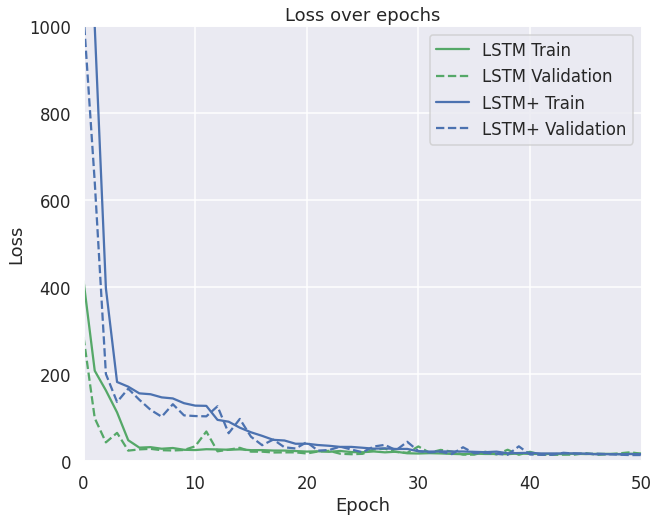

<Figure size 432x288 with 0 Axes>

In [0]:
sns.set_style('darkgrid')
sns.set_context("talk")
plt.figure(figsize=(10,8))
plt.plot(l_history.history['loss'], 'g-')
plt.plot(l_history.history['val_loss'], 'g--')
plt.plot(le_history.history['loss'], 'b-')
plt.plot(le_history.history['val_loss'], 'b--')
plt.ylim(0,1000)
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['LSTM Train', 'LSTM Validation', 'LSTM+ Train', 'LSTM+ Validation'], loc='best')
plt.xlim((0,50))
plt.show()

plt.savefig('./drive/My Drive/training_history.png')

### Save the models

In [0]:
## save the models
path =  './drive/My Drive/LSTM_only_modelv3.h5'
lstm_only_model.save_weights(path)
path2 = './drive/My Drive/LSTMandEmbedding_model_tfv3.h5'
lstm_embedding_model.save_weights(path2)

## load the models
# lstm_only_model.load_weights(path)
# lstm_embedding_model.load_weights(path2)

### Show some predictions

In [0]:

lstm_pred= lstm_only_model.predict(X_temporal_test)
lstm_em_pred = lstm_embedding_model.predict([X_temporal_test, X_embedding_test])



display_limit = 10
for l_pred, le_pred, exp_quant in zip(lstm_pred[:display_limit],lstm_em_pred[:display_limit], Y_quant_test[:display_limit]):
# for le_pred, exp_quant in zip(lstm_em_pred[:display_limit], Y_quant_test[:display_limit]):
    print("================================================")
    # print(inputs)
    print("Expected quant:", exp_quant, " LSTM Prediction:", l_pred[0],' LSTM+ Prediction:', le_pred[0])
    # print("Expected quant:", exp_quant, ' LSTM+ Prediction:', le_pred[0])

Expected quant: 0.00078892166  LSTM Prediction: 0.00077357586  LSTM+ Prediction: 0.0007172559
Expected quant: 0.0008078096  LSTM Prediction: 0.0007847721  LSTM+ Prediction: 0.00075308734
Expected quant: 0.00080494565  LSTM Prediction: 0.00081079884  LSTM+ Prediction: 0.0008290776
Expected quant: 0.0012172437  LSTM Prediction: 0.000791925  LSTM+ Prediction: 0.0008392766
Expected quant: 0.0008116622  LSTM Prediction: 0.0007584414  LSTM+ Prediction: 0.0008064447
Expected quant: 0.00078902993  LSTM Prediction: 0.00077489356  LSTM+ Prediction: 0.000769431
Expected quant: 0.00092394196  LSTM Prediction: 0.0007588108  LSTM+ Prediction: 0.0007499194
Expected quant: 0.0006925885  LSTM Prediction: 0.00072961464  LSTM+ Prediction: 0.000722271
Expected quant: 0.00076892367  LSTM Prediction: 0.0007721306  LSTM+ Prediction: 0.00074332237
Expected quant: 0.0006410528  LSTM Prediction: 0.00054562837  LSTM+ Prediction: 0.0005579804


In [0]:
X_temporal_test.shape
X_embedding_test.shape

(938, 50)

**Explained variance regression score function** - Best possible score is 1.0, lower values are worse.

**Max Error** - calculates the maximum residual error, the best value is 0.0.

**Mean absolute error** - Mean absolute error regression loss, the best value is 0.0.

**Mean squared error** - MSE regression loss, If squared = True returns MSE value, if False returns RMSE value, the best value is 0.0.


**Mean squared logarithmic error** - MSLE regression loss, the best value is 0.

**R^2 (coefficient of determination)** - R2 regression score function. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.






In [0]:
from sklearn import metrics as skm

metrics = {'Explained variance': skm.explained_variance_score,
           'Max error':skm.max_error,
           'MAE':skm.mean_absolute_error,
           'MSE':(lambda y_true, y_pred: skm.mean_squared_error(y_true, y_pred, squared=True)),
           'RMSE':(lambda y_true, y_pred: skm.mean_squared_error(y_true, y_pred, squared=False)),
           'MSLE':skm.mean_squared_log_error,
           'R2':skm.r2_score}


lstm_metrics = {k:v(Y_quant_test, lstm_pred) for k,v in metrics.items()}
lstm_metrics
lstm_em_metrics = {k:v(Y_quant_test, lstm_em_pred) for k,v in metrics.items()}

results = pd.concat([pd.Series(lstm_metrics, name='LSTM' ), pd.Series(lstm_em_metrics, name='LSTM+')], axis=1)

display(results)


,LSTM,LSTM+
Explained variance,0.000588,0.000032
Max error,0.104687,0.104699
MAE,0.000397,0.000398
MSE,0.000014,0.000014
RMSE,0.003779,0.003780
MSLE,0.000013,0.000013
R2,-0.008287,-0.008896


In [0]:
sns.set_style('darkgrid')
sns.set_context("talk")


plt.figure(figsize=(30,10))

grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)

ax1 = plt.subplot(grid[:,0])
ax1.scatter(Y_quant_test,lstm_em_pred,label='LSTM+' )
ax1.scatter(Y_quant_test, lstm_pred, label='LSTM')
ax1.set_xlim(left=0, right=0.005)
ax1.set_title('Full Scale')

ax2 = plt.subplot(grid[0,1])
ax2.scatter(Y_quant_test,lstm_em_pred,label='LSTM+' )
ax2.scatter(Y_quant_test, lstm_pred, label='LSTM')
ax2.set_xlim(left=0, right=0.0008)
ax2.set_title('Low cutoff')

ax3 = plt.subplot(grid[1,1])
ax3.scatter(Y_quant_test,lstm_em_pred,label='LSTM+' )
ax3.scatter(Y_quant_test, lstm_pred, label='LSTM')
ax3.set_xlim(left=0.0015, right=0.005)
ax3.set_title('High cutoff')

plt.legend()
plt.show();

plt.savefig('./drive/My Drive/regression_results.png');



# plt.xlim((0,0.001))
# plt.show()


NameError: ignored

# Updated!



In [0]:
#Will retrieve the quantity ordered for the past 7 weeks from the given date
def build_inputs_for_row(product, row):

    temporal_inputs = row[1]['temporal_inputs']
    product_embedding_data = row[1]['prod_embedding']
    return product_embedding_data, temporal_inputs

In [0]:
#Take a dataframe in input, will do the predictions and return the dataframe with extra rows
#containing the predictions
def predict_for_product(product,testing_df):
    
    prod_df = testing_df[testing_df['product_id']==product]
    df_result = pd.DataFrame(columns=['product_id', 'end_date', 'actual_qty', 'pred_quantity'])

    for row in prod_df.iterrows():
        product_embedding_data, temporal_inputs= build_inputs_for_row(product, row)
        item = lstm_embedding_model.predict([temporal_inputs.reshape(1,7,4), 
                                            product_embedding_data.reshape(1,50)])
        
        df_result = df_result.append({'product_id':product, 
                                      'end_date':row[1]['order_date'],  
                                      'actual_qty': row[1]['expected_qty'],
                                      'pred_quantity': item[0][0],	
                        }, ignore_index=True)
    return df_result

In [0]:
predict_for_product(540, testing_df)

,product_id,end_date,actual_qty,pred_quantity
0,540,2011-03-20,0.000610,0.000778
1,540,2009-05-17,0.001383,0.000796
2,540,2009-10-04,0.003366,0.000808
3,540,2012-01-22,0.001098,0.000786


In [0]:
#The functions that are called here need to optimise, sorry about that!
#copy_df = train_df

result = pd.DataFrame(columns=['product_id', 'end_date', 'actual_qty', 'pred_quantity'])
with tqdm(total=len(list(testing_df.product_id.unique()))) as pbar:
    for product in testing_df.product_id.unique():
      result = result.append(predict_for_product(product, testing_df), ignore_index=True)
      pbar.update(1)
aggdisplay(result)

,product_id,end_date,actual_qty,pred_quantity
0,121,2010-03-28,0.000784,0.000836
1,121,2009-11-29,0.000788,0.000807
2,241,2009-06-14,0.000723,0.000789
3,241,2009-07-12,0.000709,0.000781
4,241,2009-12-27,0.000766,0.000804
...,...,...,...,...
933,514,2010-01-17,0.000789,0.000805
934,681,2012-07-29,0.000316,0.000722
935,336,2009-10-18,0.000814,0.000721
936,176,2010-02-21,0.000712,0.000814


In [0]:
eval_by_product = pd.DataFrame()
for product in testing_df.product_id.unique():
  y_pred = result[result['product_id']==product].pred_quantity.values
  y_act = result[result['product_id']==product].actual_qty.values
  metric_values = {k:v(y_act, y_pred) for k,v in metrics.items() if k!='MSLE' and k!='R2'}
  metric_values['product_id']=int(product)
  eval_by_product = eval_by_product.append(metric_values, ignore_index=True)
eval_by_product.set_index('product_id', drop=True, inplace=True)
eval_by_product.index = eval_by_product.index.astype(int)
eval_by_product.sort_index(inplace=True)

In [0]:
eval_by_product.index = eval_by_product

RangeIndex(start=0, stop=368, step=1)

In [0]:
eval_by_product

,Explained variance,MAE,MSE,Max error,RMSE
4,-23.325213,0.000139,2.439872e-08,0.000239,0.000156
5,1.000000,0.000618,3.817081e-07,0.000618,0.000618
6,-8.525799,0.000056,3.332303e-09,0.000071,0.000058
8,0.046639,0.000086,9.141321e-09,0.000143,0.000096
10,1.000000,0.000041,1.711801e-09,0.000041,0.000041
...,...,...,...,...,...
721,1.000000,0.000016,2.604467e-10,0.000016,0.000016
723,-109.916235,0.000134,4.054429e-08,0.000394,0.000201
724,-4006.544417,0.000100,1.379902e-08,0.000162,0.000117
725,1.000000,0.000112,1.257137e-08,0.000112,0.000112


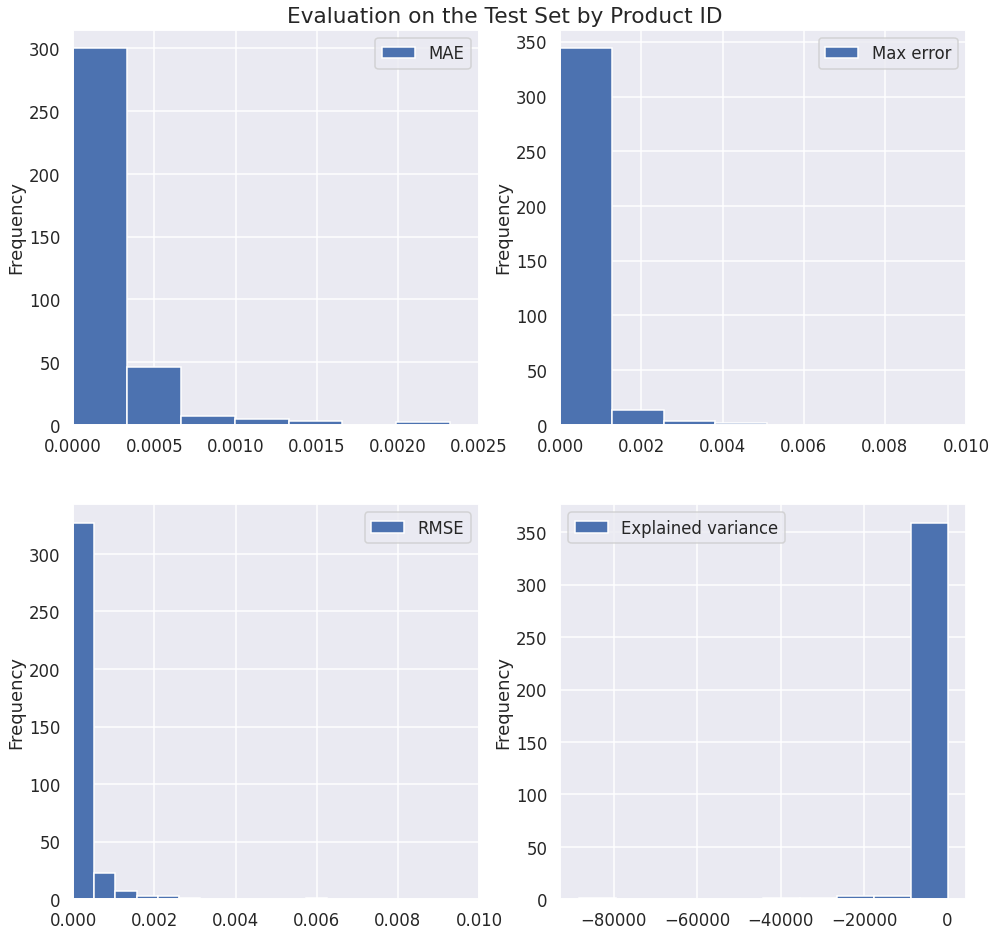

In [0]:
sns.set_context('talk')
plt.figure(figsize=(16,16))
ax1=plt.subplot(221)
eval_by_product[['MAE']].plot.hist(ax=ax1, bins=50, xlim=(0,0.0025))
ax2=plt.subplot(222)
eval_by_product[['Max error']].plot.hist(ax=ax2, bins=75, xlim=(0,0.01))
ax3=plt.subplot(223)
eval_by_product[['RMSE']].plot.hist(ax=ax3, bins=75, xlim=(0,0.01))
ax4=plt.subplot(224)
eval_by_product[['Explained variance']].plot.hist(ax=ax4)
plt.suptitle('Evaluation on the Test Set by Product ID',y=0.9);



In [0]:
eval_by_product.sort_values('MAE')

,Explained variance,MAE,MSE,Max error,RMSE
104,1.000000,1.340459e-07,1.796830e-14,1.340459e-07,1.340459e-07
156,1.000000,5.258059e-07,2.764718e-13,5.258059e-07,5.258059e-07
517,1.000000,7.503522e-07,5.630285e-13,7.503522e-07,7.503522e-07
633,1.000000,1.534111e-06,2.353496e-12,1.534111e-06,1.534111e-06
44,1.000000,1.578765e-06,2.492498e-12,1.578765e-06,1.578765e-06
...,...,...,...,...,...
637,1.000000,3.029745e-03,9.179352e-06,3.029745e-03,3.029745e-03
555,-0.005300,3.414485e-03,3.578928e-05,1.184506e-02,5.982414e-03
215,0.003694,5.537784e-03,1.480623e-04,2.720757e-02,1.216808e-02
662,-0.003507,1.342924e-02,5.958668e-04,4.863971e-02,2.441038e-02
